In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210609'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:01, 10.28it/s]


(636850, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(634283, 21)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '구로구'
target_dong = '개봉동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 36 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(847, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
88495,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,59.940,34.14,27800,5,2018.0,0.0,2018-06-14,463.797130,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동
88496,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,55.130,31.40,26800,2,2018.0,0.0,2018-06-14,486.123708,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동
88497,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,40.195,22.89,19550,2,2018.0,0.0,2018-06-14,486.378903,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동
88498,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,52.005,29.62,25250,2,2018.0,0.0,2018-06-14,485.530237,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동
88499,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,55.130,31.40,26800,3,2018.0,0.0,2018-06-14,486.123708,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(847, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
88495,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,59.940,34.14,27800,5,2018.0,0.0,2018-06-14,463.797130,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동,563.535359,2021-03-01
88496,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,55.130,31.40,26800,2,2018.0,0.0,2018-06-14,486.123708,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동,590.663202,2021-03-01
88497,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,40.195,22.89,19550,2,2018.0,0.0,2018-06-14,486.378903,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동,590.973276,2021-03-01
88498,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,52.005,29.62,25250,2,2018.0,0.0,2018-06-14,485.530237,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동,589.942107,2021-03-01
88499,서울특별시 구로구 개봉동 111-8,고척로27다길 11,오성드림빌,55.130,31.40,26800,3,2018.0,0.0,2018-06-14,486.123708,3.0,연립다세대,대,1551.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,구로구,개봉동,590.663202,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 구로구 개봉동 105-12,영모던빌,5.0,27.01,2020-07-09,16800,621.991855,2021-03-01,668.573189,제3종일반주거지역,연립다세대
1,서울특별시 구로구 개봉동 105-12,영모던빌,5.0,27.47,2020-08-19,15500,564.251911,2021-03-01,606.384421,제3종일반주거지역,연립다세대
2,서울특별시 구로구 개봉동 108-19,혜성팰리스,2.0,29.70,2020-01-23,26300,885.521886,2021-03-01,1010.464182,제2종일반주거지역,연립다세대
3,서울특별시 구로구 개봉동 108-22,대영리더스빌,3.0,46.68,2018-08-22,23500,503.427592,2021-03-01,598.800764,제2종일반주거지역,연립다세대
4,서울특별시 구로구 개봉동 108-22,대영리더스빌,3.0,47.28,2018-08-22,23200,490.693739,2021-03-01,583.654513,제2종일반주거지역,연립다세대


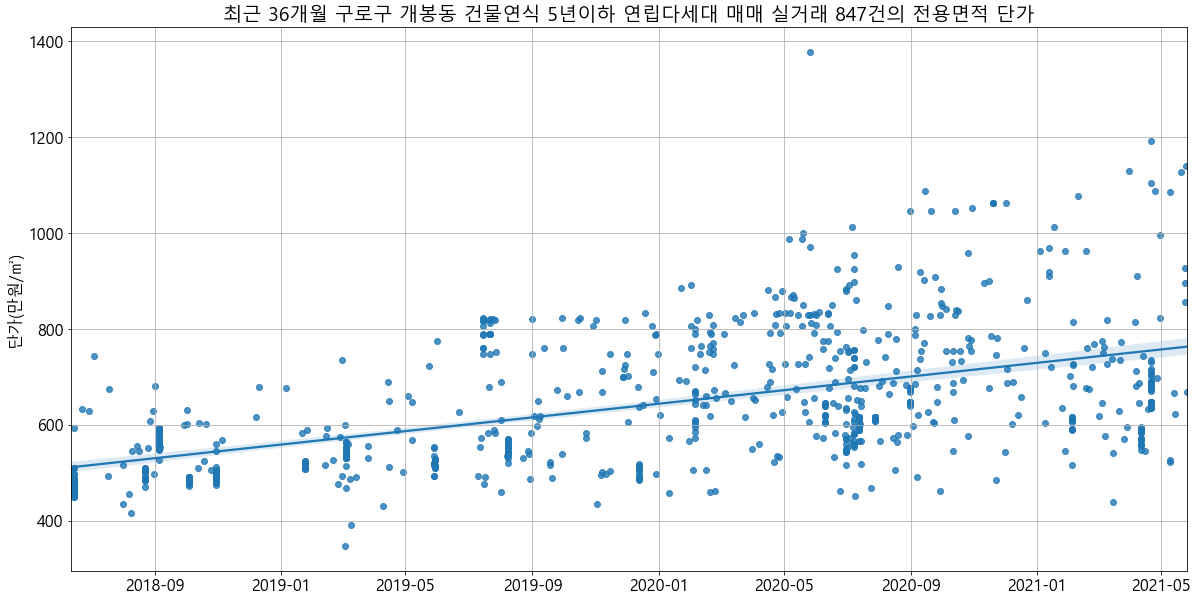

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

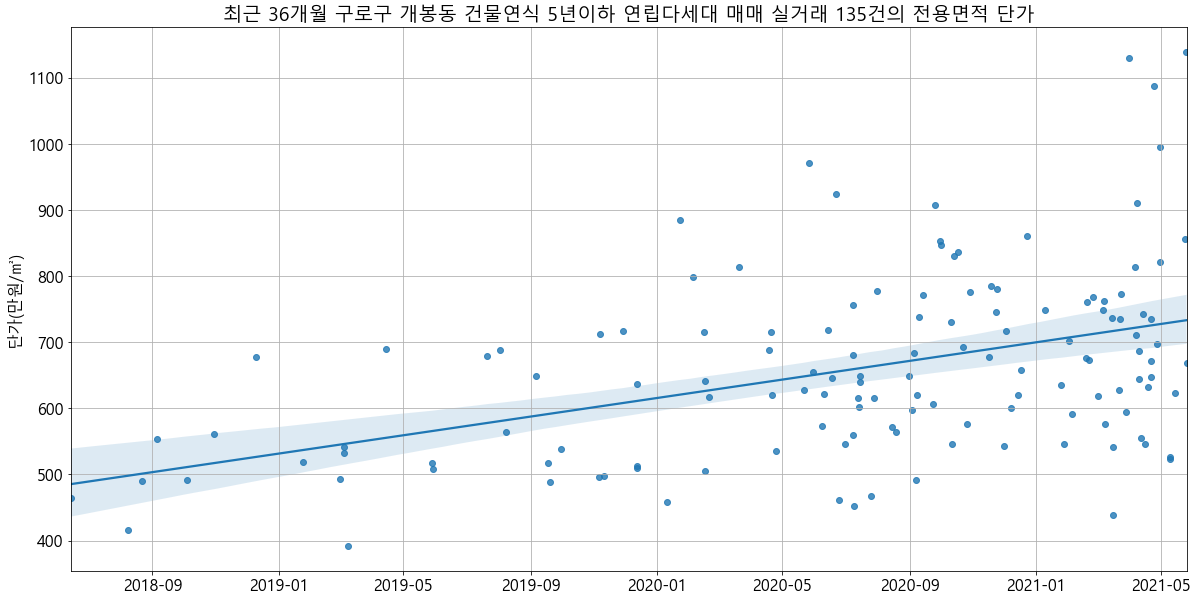

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(4097, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
86747,서울특별시 구로구 개봉동 153-81,고척로52마길 7-29,(153-81),46.18,26.85,9600,3,2002.0,4.0,2006-11-03,207.882200,19.0,연립다세대,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),구로구,개봉동
86748,서울특별시 구로구 개봉동 153-81,고척로52마길 7-29,(153-81),47.28,27.49,9600,2,2002.0,4.0,2006-11-03,203.045685,19.0,연립다세대,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),구로구,개봉동
86749,서울특별시 구로구 개봉동 153-81,고척로52마길 7-29,(153-81),70.38,40.91,14000,1,2002.0,4.0,2006-11-08,198.920148,19.0,연립다세대,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),구로구,개봉동
86750,서울특별시 구로구 개봉동 153-81,고척로52마길 7-29,(153-81),46.84,27.23,9600,3,2002.0,4.0,2006-11-13,204.953032,19.0,연립다세대,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),구로구,개봉동
86751,서울특별시 구로구 개봉동 153-81,고척로52마길 7-29,(153-81),46.62,27.10,9600,2,2002.0,4.0,2006-11-20,205.920206,19.0,연립다세대,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),구로구,개봉동


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'구로구 개봉동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 4097건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

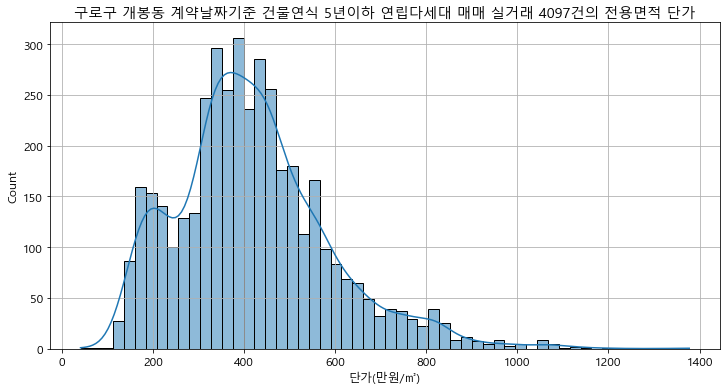

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(2181, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 구로구 개봉동 10-28,고척로21다길 20-14,OK빌리지A동,56.04,24.43,9100,4,2002.0,4.0,2006-10-28,162.384011,19.0,연립다세대,대,229.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,구로구,개봉동,327.200498,2021-03-01,162.384011,327.200498
1,서울특별시 구로구 개봉동 10-32,고척로21다길 20-5,하나빌리지,60.57,29.30,9500,1,2002.0,5.0,2007-01-08,156.843322,19.0,연립다세대,대,238.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),구로구,개봉동,291.614722,2021-03-01,156.843322,291.614722
2,서울특별시 구로구 개봉동 10-34,고척로21다길 20-13,부영파크빌(10-34),60.72,28.63,14600,2,2005.0,3.0,2008-03-10,240.447958,16.0,연립다세대,대,229.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,구로구,개봉동,331.023784,2021-03-01,240.447958,331.023784
3,서울특별시 구로구 개봉동 10-36,고척로21다길 28-10,상우하이츠빌(10-36),63.99,36.37,15000,2,2003.0,5.0,2008-03-30,234.411627,18.0,연립다세대,대,117.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),구로구,개봉동,322.713590,2021-03-01,217.216864,331.546448
4,서울특별시 구로구 개봉동 10-36,고척로21다길 28-10,상우하이츠빌(10-36),90.49,51.45,18100,4,2003.0,4.0,2007-06-11,200.022102,18.0,연립다세대,대,117.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),구로구,개봉동,340.379306,2021-03-01,217.216864,331.546448


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(759, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 구로구 개봉동 10-28,고척로21다길 20-14,OK빌리지A동,56.04,24.43,9100,4,2002.0,4.0,2006-10-28,162.384011,19.0,연립다세대,대,229.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,구로구,개봉동,327.200498,2021-03-01,162.384011,327.200498
1,서울특별시 구로구 개봉동 10-32,고척로21다길 20-5,하나빌리지,60.57,29.30,9500,1,2002.0,5.0,2007-01-08,156.843322,19.0,연립다세대,대,238.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),구로구,개봉동,291.614722,2021-03-01,156.843322,291.614722
2,서울특별시 구로구 개봉동 10-34,고척로21다길 20-13,부영파크빌(10-34),60.72,28.63,14600,2,2005.0,3.0,2008-03-10,240.447958,16.0,연립다세대,대,229.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,구로구,개봉동,331.023784,2021-03-01,240.447958,331.023784
4,서울특별시 구로구 개봉동 10-36,고척로21다길 28-10,상우하이츠빌(10-36),90.49,51.45,18100,4,2003.0,4.0,2007-06-11,200.022102,18.0,연립다세대,대,117.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),구로구,개봉동,340.379306,2021-03-01,217.216864,331.546448
10,서울특별시 구로구 개봉동 10-40,고척로21다길 28-3,형지파크빌,46.09,27.89,19100,3,2017.0,0.0,2017-08-08,414.406596,4.0,연립다세대,대,229.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),구로구,개봉동,524.749444,2021-03-01,423.961744,536.848814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2172,서울특별시 구로구 개봉동 90-83,경인로33바길 53-7,주은빌라,53.17,30.21,19600,2,2003.0,4.0,2007-11-28,368.628926,18.0,연립다세대,대,338.0,제3종일반주거지역,지정되지않음,아파트,평지,사다리형,광대소각,구로구,개봉동,568.324249,2021-03-01,356.512334,570.143029
2173,서울특별시 구로구 개봉동 90-84,경인로33바길 53-5,주은빌라(90-84),72.72,44.16,26000,2,2003.0,5.0,2008-04-02,357.535754,18.0,연립다세대,대,152.0,제3종일반주거지역,지정되지않음,아파트,평지,사다리형,광대소각,구로구,개봉동,474.675707,2021-03-01,357.535754,474.675707
2178,서울특별시 구로구 개봉동 90-85,경인로33바길 53-3,비젼아트빌 B동(90-85),41.49,22.41,15000,3,2002.0,5.0,2007-11-06,361.532899,19.0,연립다세대,대,152.0,제3종일반주거지역,지정되지않음,아파트,평지,사다리형,광대소각,구로구,개봉동,557.384131,2021-03-01,342.730503,586.452011
2179,서울특별시 구로구 개봉동 92-7,고척로 115-6,원크리스탈(92-7),61.08,26.45,12000,2,2002.0,4.0,2006-10-11,196.463654,19.0,연립다세대,대,232.0,제3종일반주거지역,지정되지않음,다세대,평지,세로장방,세로각지(가),구로구,개봉동,395.870289,2021-03-01,196.463654,395.870289


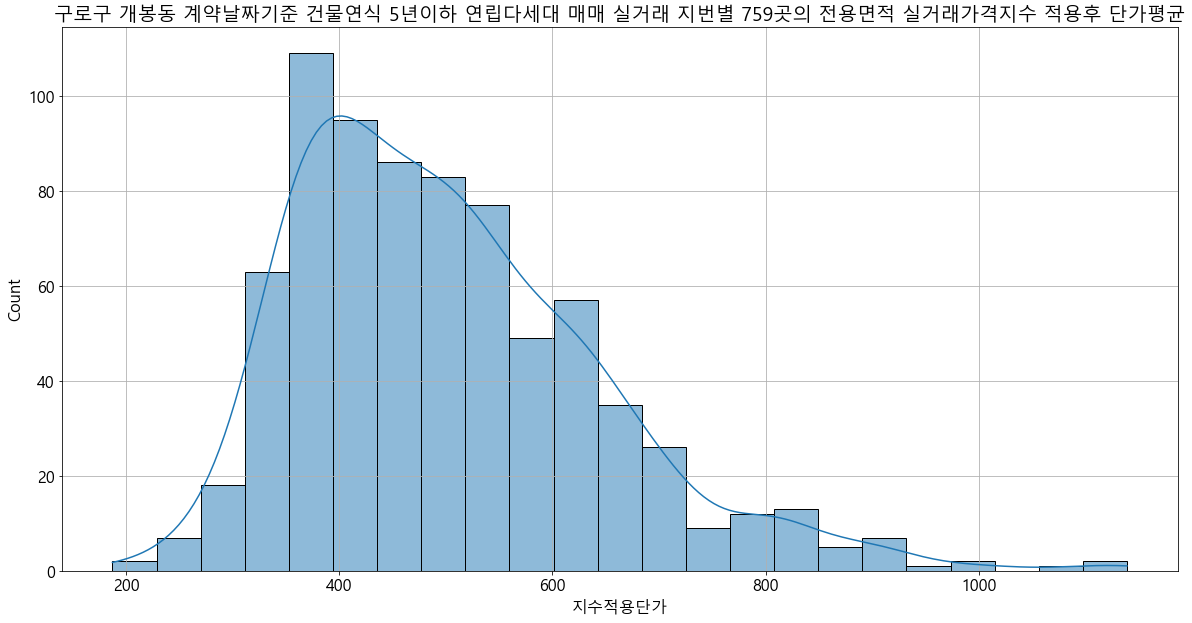

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 구로구 개봉동 10-28,OK빌리지A동,2002.0,56.04,2006-10-28,162.384011,2021-03-01,327.200498,제2종일반주거지역,연립다세대
1,서울특별시 구로구 개봉동 10-32,하나빌리지,2002.0,60.57,2007-01-08,156.843322,2021-03-01,291.614722,제2종일반주거지역,연립다세대
2,서울특별시 구로구 개봉동 10-34,부영파크빌(10-34),2005.0,60.72,2008-03-10,240.447958,2021-03-01,331.023784,제2종일반주거지역,연립다세대
3,서울특별시 구로구 개봉동 10-36,상우하이츠빌(10-36),2003.0,90.49,2007-06-11,200.022102,2021-03-01,340.379306,제2종일반주거지역,연립다세대
4,서울특별시 구로구 개봉동 10-40,형지파크빌,2017.0,46.09,2017-08-08,414.406596,2021-03-01,524.749444,제2종일반주거지역,연립다세대


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)